# Human spermatogenesis manifold analyses

In this notebook we show the analyses discussed in Sec. VII of 'Parameter-free representations outperform single-cell foundation models on downstream benchmarks'. We show the analysis for human spermatogenesis dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import sctop as top
import scanpy as sc
import re
from collections import defaultdict
import time
from transcriptformer.datasets import bgee_testis_evolution
import anndata as ad
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
import os

specie = 'human'

def balanced_subsample(adata, group_key, n_per_class=500, random_state=42):
    """
    Subsamples the AnnData object to have at most n_per_class cells per group.
    """
    print(f"--- Downsampling balanced by '{group_key}' ---")
    np.random.seed(random_state)
    
    # Get indices for each class
    indices_to_keep = []
    classes = adata.obs[group_key].unique()
    
    for cls in classes:
        cls_indices = np.where(adata.obs[group_key] == cls)[0]
        n_cells = len(cls_indices)
        
        if n_per_class < 100:
            continue
        
        if n_cells > n_per_class:
            # Randomly sample if class is too large
            selected = np.random.choice(cls_indices, n_per_class, replace=False)
        else:
            # Keep all if class is small
            selected = cls_indices
            
        indices_to_keep.append(selected)
        print(f"   Class '{cls}': {n_cells} -> {len(selected)} cells")
    
    # Flatten and sort indices
    final_indices = np.concatenate(indices_to_keep)
    final_indices.sort()
    
    return adata[final_indices].copy()

def analyze_manifold_curvature(X, k_list=[15, 30], max_dim_pca=300, max_dim_iso=120):
    """
    Runs PCA vs Isomap analysis on the data matrix X (n_cells x n_features).
    """
    results = {
        'pca_residuals': [],
        'distortion_scores': {}
    }
    
    print(f"1. Computing Euclidean distances for {X.shape[0]} cells...")
    D_euc = pairwise_distances(X, metric='euclidean')
    flat_D_euc = D_euc.reshape(-1)
    
    print(f"2. Running PCA up to {max_dim_pca} dimensions...")
    pca = PCA(n_components=max_dim_pca)
    pca.fit(X)
    results['pca_residuals'] = 1 - np.cumsum(pca.explained_variance_ratio_)
    
    for k in k_list:
        print(f"3. Analyzing Neighbor Graph (k={k})...")
        iso_graph = Isomap(n_neighbors=k, n_components=5, n_jobs=-1)
        iso_graph.fit(X)
        D_geo = iso_graph.dist_matrix_
        
        flat_D_geo = D_geo.reshape(-1)
        valid_mask = np.isfinite(flat_D_geo)
        
        if np.sum(valid_mask) < len(valid_mask):
            print(f"   Warning: Graph is disconnected at k={k}. Using valid paths only.")
            
        correlation, _ = pearsonr(flat_D_euc[valid_mask], flat_D_geo[valid_mask])
        results['distortion_scores'][k] = correlation
        print(f"   -> Distortion Score (Euclidean-Geodesic Corr): {correlation:.4f}")
    

    return results

sns.set_theme(context="notebook", style="whitegrid", font_scale=1.2)

def plot_manifold_metrics(results, path=None, title_prefix=""):
    plt.figure(figsize=(6, 6))

    ks = list(results['distortion_scores'].keys())
    scores = list(results['distortion_scores'].values())
    plt.plot(ks, scores, 'bs-', lw=2, markersize=8)
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Pearson Correlation')
    plt.ylim(0, 1.05)
    plt.title(f'Euclidean vs Geodesic distance')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=300, transparent=True, bbox_inches = 'tight')
    plt.show()

# ==========================================
# 4. Execution Block
# ==========================================
if __name__ == "__main__":
    
    adata = bgee_testis_evolution(organism=specie)
    adata_sampled = balanced_subsample(adata, group_key='cell_type', n_per_class=500)
        
    print("Starting Analysis...")
    results = analyze_manifold_curvature(adata_sampled.X, k_list=[5, 10, 15, 30, 45])

--- Downsampling balanced by 'cell_type' ---
   Class 'late spermatid': 2382 -> 500 cells
   Class 'male germ line stem cell': 2123 -> 500 cells
   Class 'spermatocyte': 3765 -> 500 cells
   Class 'spermatogonium': 880 -> 500 cells
   Class 'early spermatid': 3921 -> 500 cells
   Class 'somatic cell': 1379 -> 500 cells
   Class 'Sertoli cell': 1339 -> 500 cells
Starting Analysis...
1. Computing Euclidean distances for 3500 cells...
2. Running PCA up to 300 dimensions...
3. Analyzing Neighbor Graph (k=5)...
   -> Distortion Score (Euclidean-Geodesic Corr): 0.9238
3. Analyzing Neighbor Graph (k=10)...
   -> Distortion Score (Euclidean-Geodesic Corr): 0.9278
3. Analyzing Neighbor Graph (k=15)...
   -> Distortion Score (Euclidean-Geodesic Corr): 0.9324
3. Analyzing Neighbor Graph (k=30)...
   -> Distortion Score (Euclidean-Geodesic Corr): 0.9429
3. Analyzing Neighbor Graph (k=45)...
   -> Distortion Score (Euclidean-Geodesic Corr): 0.9492


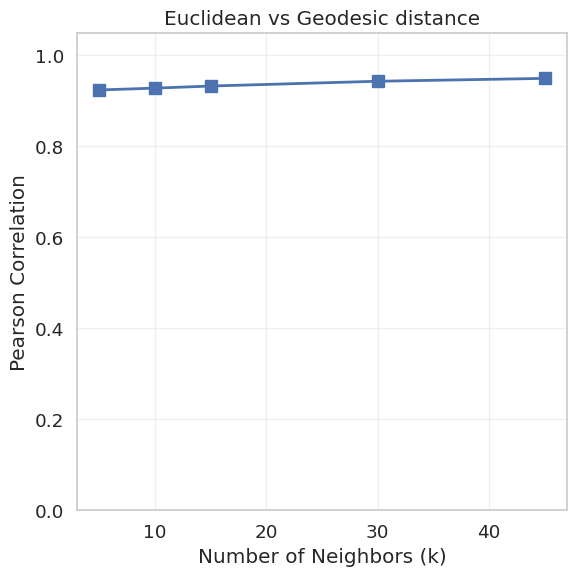

In [2]:
plot_manifold_metrics(results, path=None)

We notice that the correlation between geodesics distances and Euclidean distances is near to 1.0, meaning the structure of the manifold is well approximated by linear representations.

In [6]:
from sklearn.metrics.pairwise import euclidean_distances

def plot_class_projections(X, y, palette, title_prefix="", path=None, k_neighbors=10):
    """
    Plots PCA and Isomap (2D) projections colored by class.
    Adds explained variance to PCA axes and residual variance to Isomap title.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # --- A) PCA Projection ---
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Get explained variance ratios
    var_exp = pca.explained_variance_ratio_

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=y, palette=palette,
        s=30, alpha=0.7, ax=axes[0], legend=False
    )
    axes[0].set_title(f"PCA Projection", fontsize=26)
    # Add explained variance percentage to labels
    axes[0].set_xlabel(f"PC 1 (explained variance: {var_exp[0]:.2f})", fontsize=24)
    axes[0].set_ylabel(f"PC 2 (explained variance: {var_exp[1]:.2f})", fontsize=24)
    #axes[0].legend(fontsize=20)

    # --- B) Isomap Projection ---
    iso = Isomap(n_neighbors=k_neighbors, n_components=5, n_jobs=-1)
    try:
        X_iso = iso.fit_transform(X)
        
        # Calculate Residual Variance: 1 - R^2(Geodesic, Embedded Euclidean)
        res_var_str = ""
        if hasattr(iso, "dist_matrix_"):
            # Check for disconnected graph (infinite distances)
            if np.all(np.isfinite(iso.dist_matrix_)):
                D_geo = iso.dist_matrix_
                D_emb = euclidean_distances(X_iso)
                
                # Compute correlation between the flattened distance matrices
                corr = np.corrcoef(D_geo.ravel(), D_emb.ravel())[0, 1]
                res_var = 1 - corr**2
                res_var_str = f", Residual Variance: {res_var:.3f}"
            else:
                res_var_str = ", Res. Var: N/A (Disconnected)"

        sns.scatterplot(
            x=X_iso[:, 0], y=X_iso[:, 1],
            hue=y, palette=palette,
            s=30, alpha=0.7, ax=axes[1], legend=False
        )
        axes[1].set_title(f"Isomap (k={k_neighbors}{res_var_str})", fontsize=28)
        axes[1].set_xlabel("Iso 1", fontsize=26)
        axes[1].set_ylabel("Iso 2", fontsize=26)
        
        # Warn visually if graph is disconnected
        if hasattr(iso, "dist_matrix_") and np.any(~np.isfinite(iso.dist_matrix_)):
            axes[1].text(
                0.02, 0.02, "Graph disconnected (some geodesics = inf)",
                transform=axes[1].transAxes, color="red", weight="bold"
            )

    except Exception as e:
        print(f"Isomap Failed (k={k_neighbors}): {e}")
        axes[1].text(0.5, 0.5, "Isomap Failed", ha='center')

    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(axis='both', which='minor', labelsize=24)
    
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

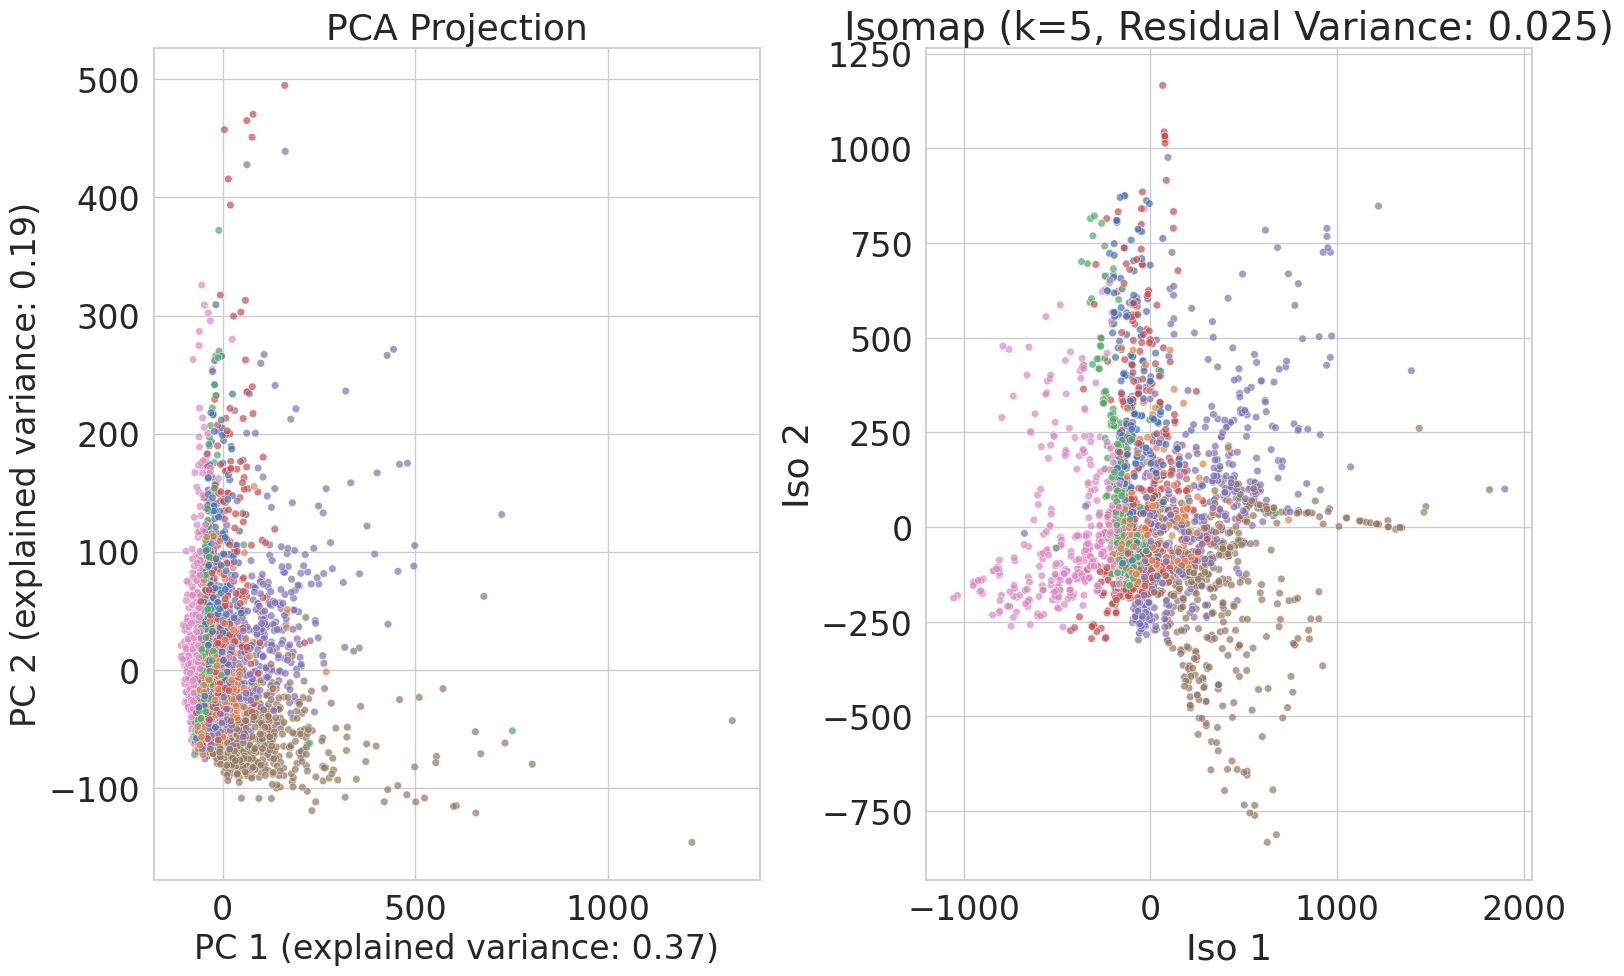

In [5]:
class_palette = sns.color_palette("deep", len(adata_sampled.obs['cell_type'].unique()))

plot_class_projections(adata_sampled.X.toarray(), np.array(adata_sampled.obs['cell_type'].values), palette=class_palette, path=None, k_neighbors=5)

We also see that using PCA or Isomap gives us qualitative similar results, supporting that the dataset is well approximated by linear representations.